#  Van Der Pol oscillator
The Van Der Pol oscillator equation is:

\begin{aligned}
\frac{d^2 y}{dt^2} + \omega_0^2 y - \epsilon \omega_0 (1 - y^2) \frac{dy}{dt} = 0,
\end{aligned}

as one can see in Paper Baty & Baty (example D with Equation 19).

In this notebook a value $\epsilon = 1$ is taken with $\omega_0 = 15$, and the initial value is $ y(t = 0) = 1 $ together with $ \frac{dy}{dt}(t = 0) = 0 $.

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch.nn as nn
import os

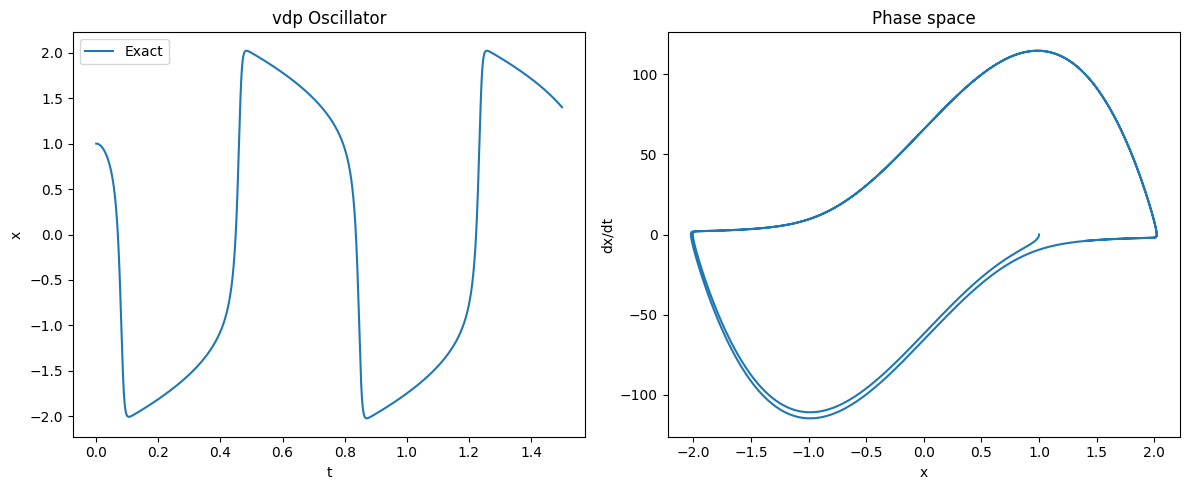

In [71]:
def vdp_oscillator(r,t,omega,nu):
    x, v = r
    dxdt = v
    dvdt = -omega**2 * x  +  nu*omega*(1 - x**2)*v
    return [dxdt, dvdt]


# Parameters
omega = 15.
nu = 5.
tMin, tMax = 0.0, 1.5
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)

#Initial conditions
r0 = [1.0, 0. ]

sol = odeint(vdp_oscillator, r0, tPoints, args=(omega, nu,))
xPoints = sol[:, 0]
vPoints = sol[:, 1]
# plot solution

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

axes[0].plot(tPoints, xPoints, label="Exact")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x")
axes[0].set_title("vdp Oscillator")
axes[0].legend()

axes[1].plot(xPoints, vPoints)
axes[1].set_xlabel("x")
axes[1].set_ylabel("dx/dt")
axes[1].set_title("Phase space")

plt.tight_layout()
plt.show()

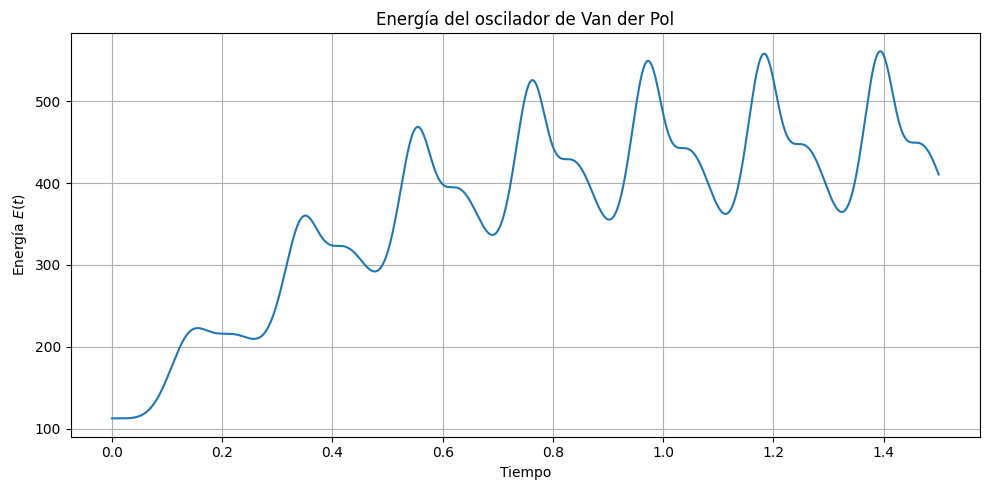

In [43]:
# Cálculo de la energía tipo
E = 0.5 * vPoints**2 + 0.5 * (omega**2) * xPoints**2

# Gráfica de la energía en el tiempo
plt.figure(figsize=(10, 5))
plt.plot(tPoints, E)
plt.xlabel("Tiempo")
plt.ylabel("Energía $E(t)$")
plt.title("Energía del oscilador de Van der Pol")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Neural Network (fully conected network)

class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_layer = nn.Sequential(*[
                    nn.Linear(in_dim, hidden_dim),
                    nn.Tanh()])
        self.hidden_layers = nn.Sequential(*[
                    nn.Sequential(*[
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Tanh()])
                    for _ in range(num_layers-1)])
        self.output_layer = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [ ]:
# General function to train a PINN model
def train_PINN(omega, nu, tMin, tMax, nSteps, epochs=72000, lr=7e-4, plot_interval=5000, 
               sample_every = 10,train_range=(0, 210), train_stride=70, Nc=48, w_d= 1.0, w_f = 1e-4):

    tPoints = np.linspace(tMin, tMax, nSteps)

    # Convert time points and solution into tensors
    x = torch.Tensor(tPoints).view(-1, 1)
    y = torch.Tensor(xPoints).view(-1, 1)

    # Subsample points for comparison
    x = x[::sample_every]
    y = y[::sample_every, :]

    # Select training data from range with given stride
    i_start, i_end = train_range
    x_data = x[i_start:i_end:train_stride]
    y_data = y[i_start:i_end:train_stride]

    # Define model, optimizer and training history containers
    torch.manual_seed(123)
    model = FCN(1, 1, 32, 3)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    mse_history = []

    # Define points for evaluating physics-based residuals
    x_physics = torch.linspace(0., 1.5, Nc).view(-1, 1).requires_grad_(True)
    x_plot = torch.linspace(tMin, tMax, 1000).view(-1, 1)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute loss from training data (data-driven loss)
        y_pred_data = model(x_data)
        loss_data = w_d * torch.mean((y_pred_data - y_data) ** 2)

        # Compute physics-informed loss (residual of differential equation)
        y_pred_physics = model(x_physics)
        dydx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]
        d2ydx2 = torch.autograd.grad(dydx, x_physics, torch.ones_like(dydx), create_graph=True)[0]
        physics_residual = d2ydx2 + omega**2 * y_pred_physics - nu * omega * (1 - y_pred_physics**2) * dydx
        loss_physics = w_f* torch.mean(physics_residual ** 2)

        # Compute mean squared error against full exact solution (evaluation only)
        yhpp = model(x)
        mse = torch.mean((yhpp - y) ** 2)

        # Combine losses and backpropagate
        loss = loss_data + loss_physics
        loss.backward()
        optimizer.step()

        # Save and optionally plot training progress
        if (epoch + 1) % 100 == 0:
            y_plot = model(x_plot).detach().numpy()
            loss_history.append(loss.detach().item())
            mse_history.append(mse.detach().item())

            # Plot predictions
            plt.figure(figsize=(8, 4))
            plt.plot(tPoints, xPoints, label="Exact")
            plt.plot(x_plot.numpy(), y_plot, '--', label="Prediction NN")
            plt.scatter(x_data.numpy(), y_data.numpy(), color="orange", label="Training data")
            plt.xlabel("t")
            plt.ylabel("x")
            plt.title(f"Epoch {epoch+1}")
            plt.legend()
            if (epoch + 1) % plot_interval == 0:
                plt.show()
            else:
                plt.close()

    return model, loss_history, mse_history

In [ ]:
def plot_training_history(loss_history, mse_history):
    import matplotlib.pyplot as plt

    epochs = np.arange(1, len(loss_history) + 1) * 100  # because we saved every 100 epochs

    # Plot Loss History
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label="Total Loss")
    plt.xlabel("Epoch")
    plt.yscale('log')
    plt.ylabel("Loss")
    plt.title("Training Loss over Time")
    plt.legend()

    # Plot MSE History
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mse_history, label="MSE vs Exact", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.title("Mean Squared Error over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()


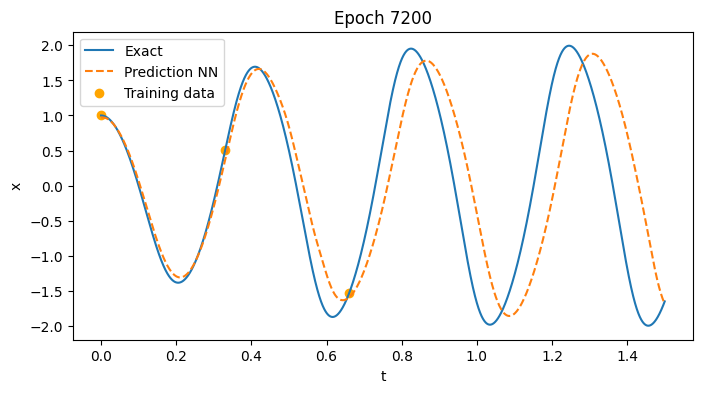

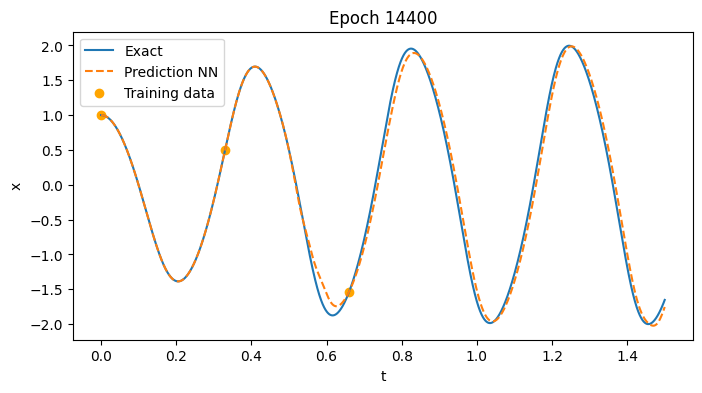

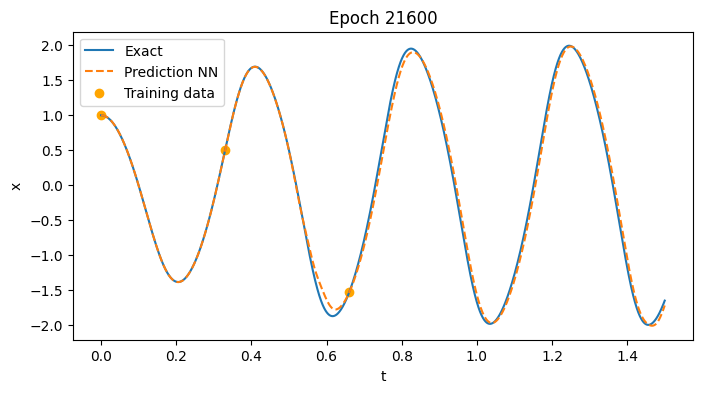

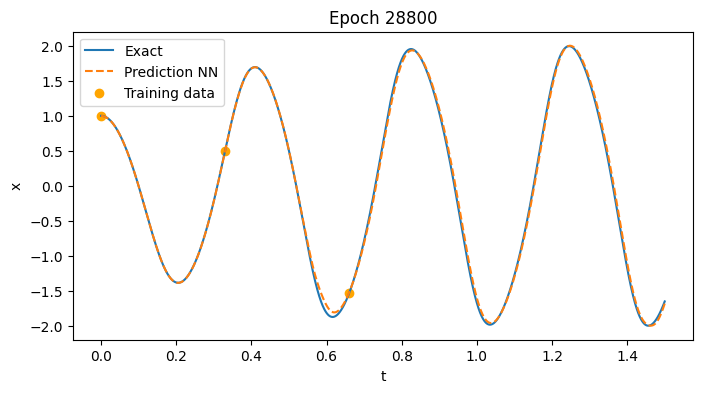

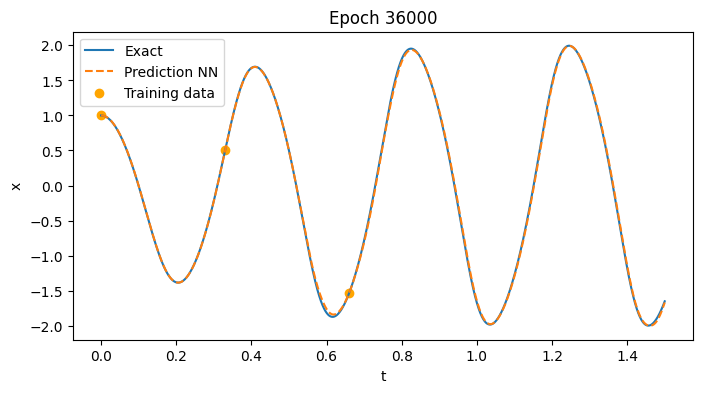

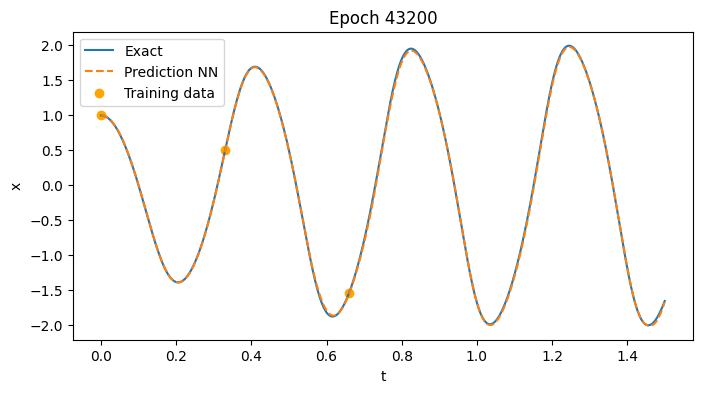

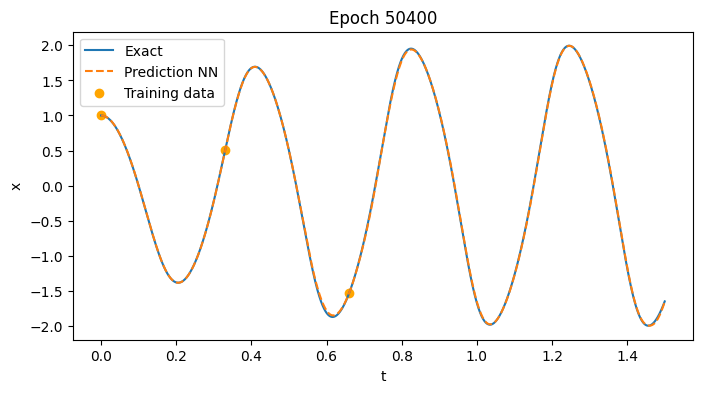

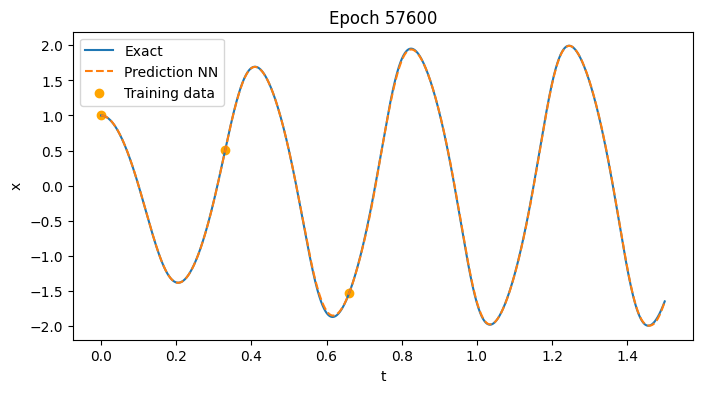

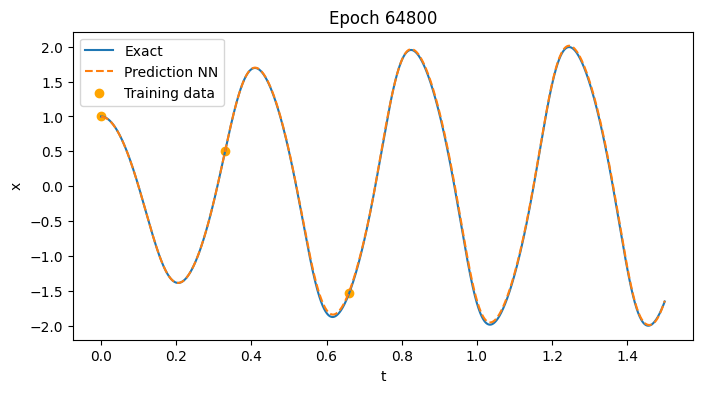

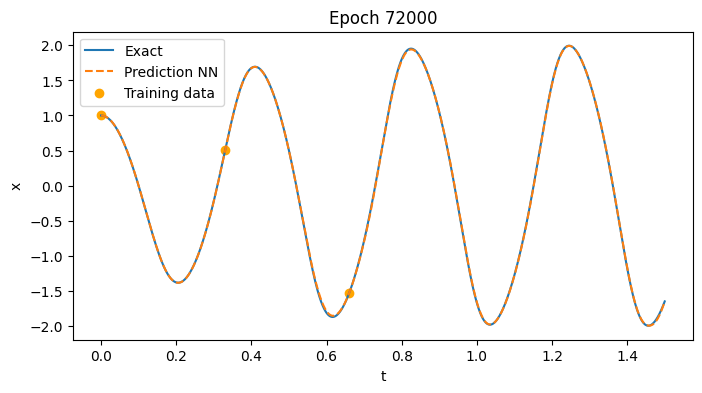

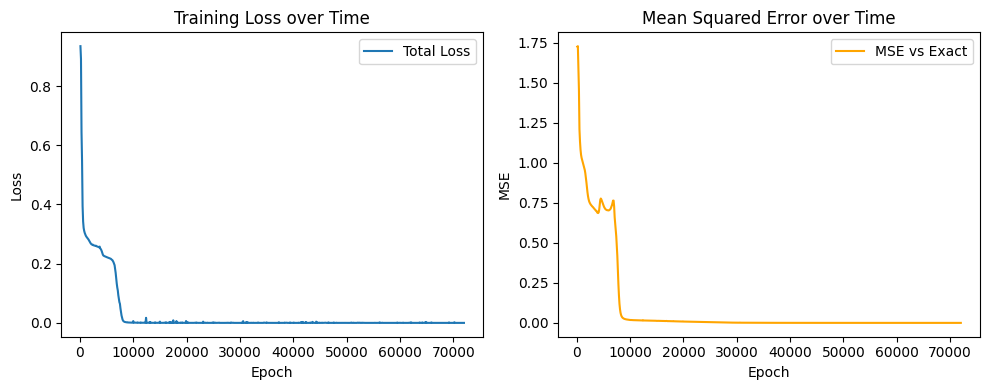

In [ ]:
#System parameters
omega = 15.
nu = 1./3.
tMin, tMax = 0.0, 1.5
r0 = [1.0, 0. ] #Initial conditions
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)
sol = odeint(vdp_oscillator, r0, tPoints, args=(omega, nu,))
xPoints = sol[:, 0]
vPoints = sol[:, 1]

#Learning parameters
epochs = 72000
plot_interval = 7200
Nc = 48 #collocation points
w_d = 1.0
w_f = 1.e-4
sample_every = 10
train_range=(0, 310)
train_stride=220
model, loss_history, mse_history = train_PINN(omega, nu, tMin, tMax, nSteps, epochs=epochs, plot_interval=plot_interval, sample_every = sample_every,
                                              train_range=train_range, train_stride=train_stride,Nc=Nc, w_d=w_d, w_f=w_f)
# Plot loss and MSE history
plot_training_history(loss_history, mse_history)

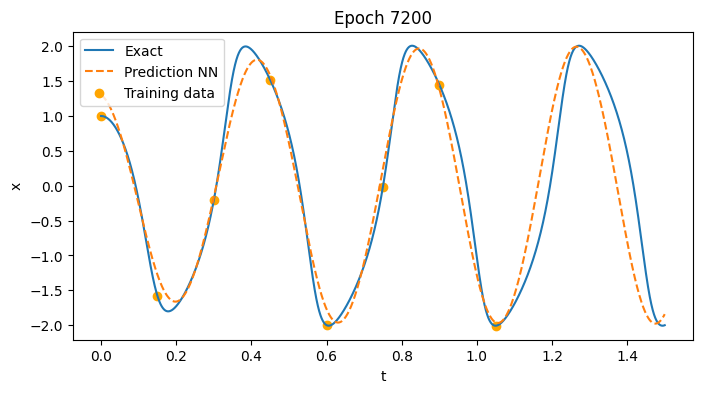

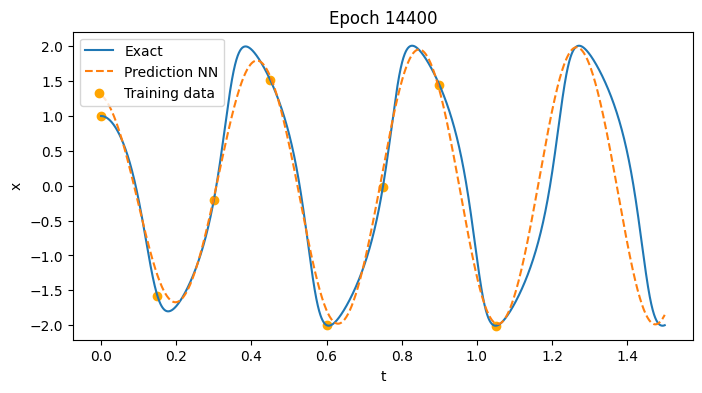

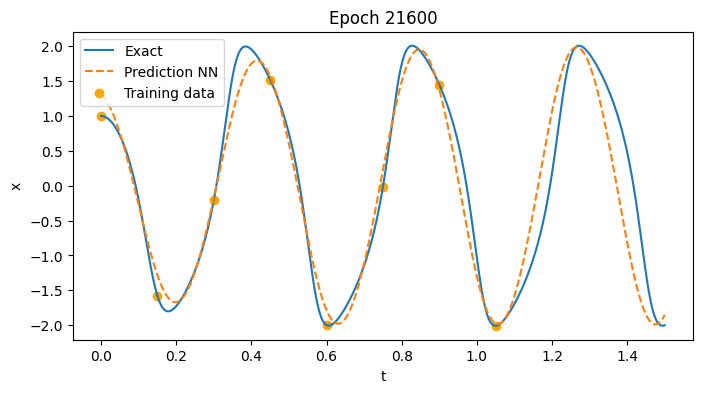

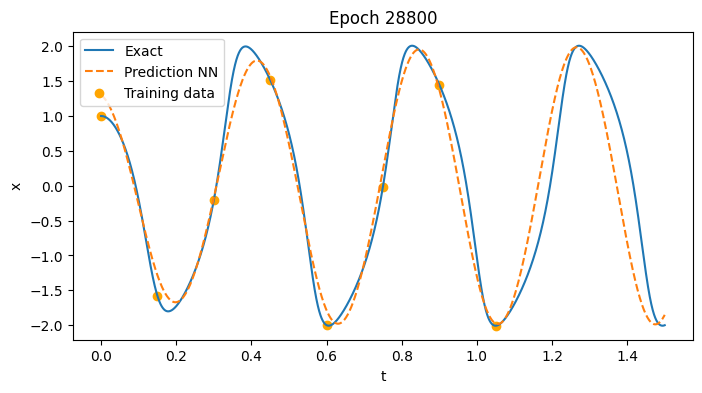

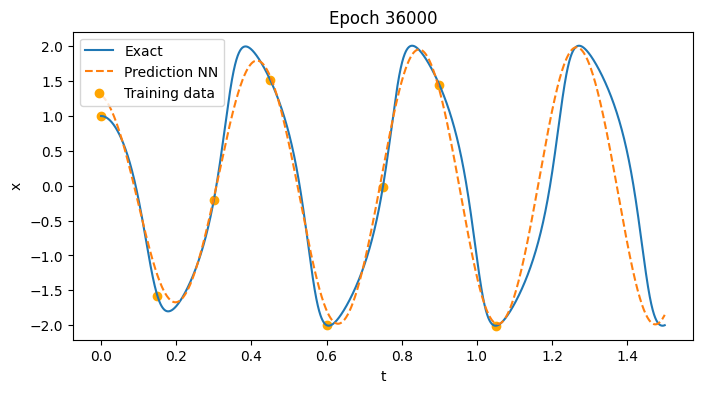

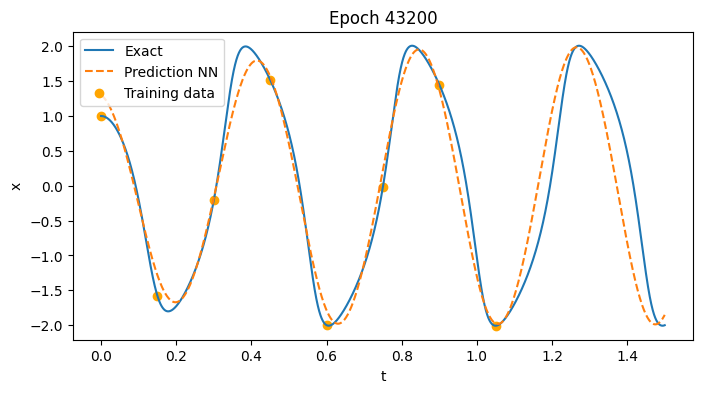

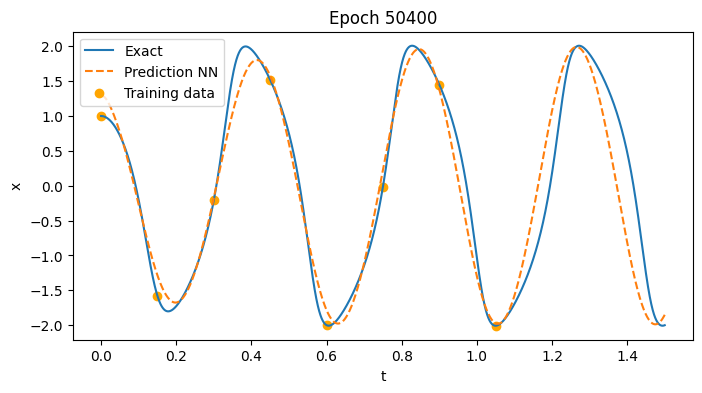

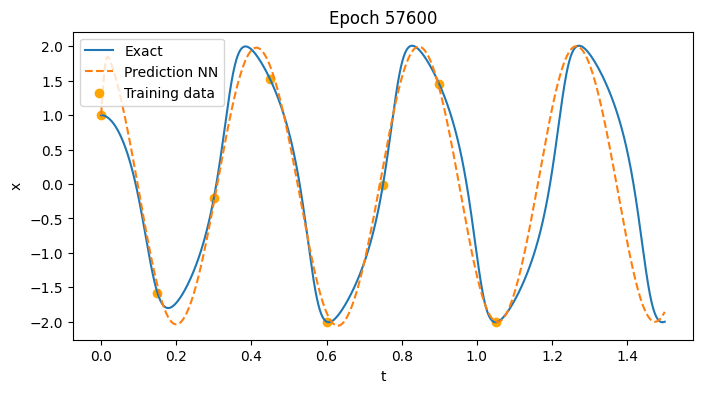

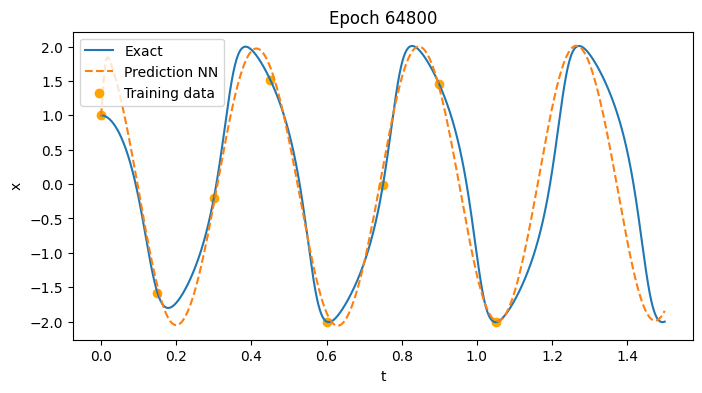

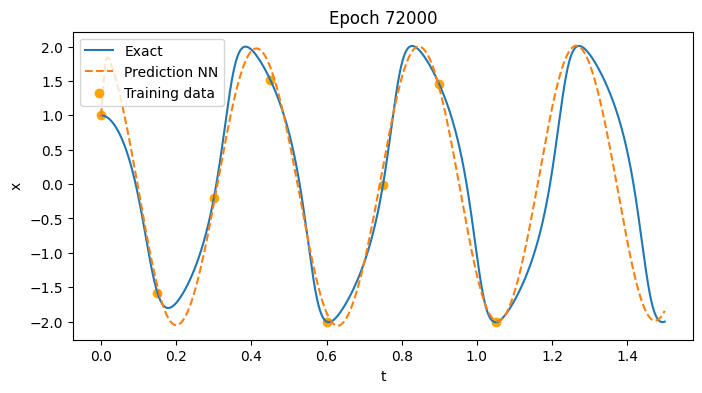

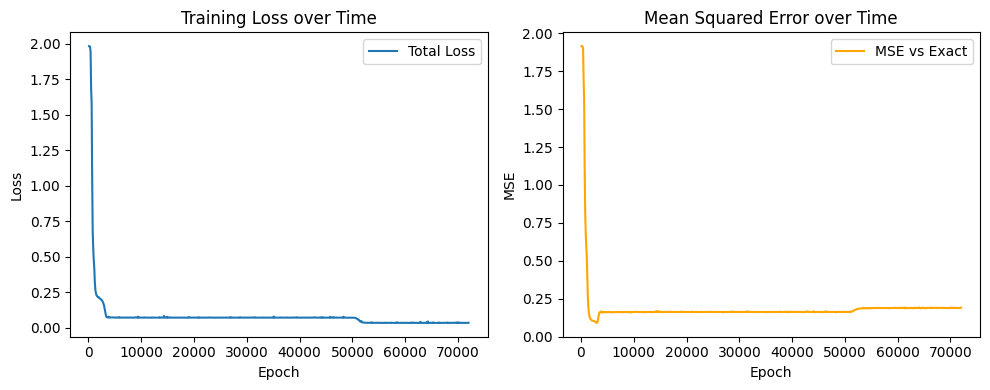

In [72]:
#System parameters
omega = 15.
nu = 1.
tMin, tMax = 0.0, 1.5
r0 = [1.0, 0. ] #Initial conditions
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)
sol = odeint(vdp_oscillator, r0, tPoints, args=(omega, nu,))
xPoints = sol[:, 0]
vPoints = sol[:, 1]

#Learning parameters
epochs = 72000
plot_interval = 7200
Nc = 60 #collocation points
w_d = 1.0
w_f = 1.e-4
sample_every = 10
train_range=(0, 800)
train_stride=100
model, loss_history, mse_history = train_PINN(omega, nu, tMin, tMax, nSteps, epochs=epochs, plot_interval=plot_interval, sample_every = sample_every,
                                              train_range=train_range, train_stride=train_stride,Nc=Nc, w_d=w_d, w_f=w_f)
# Plot loss and MSE history
plot_training_history(loss_history, mse_history)

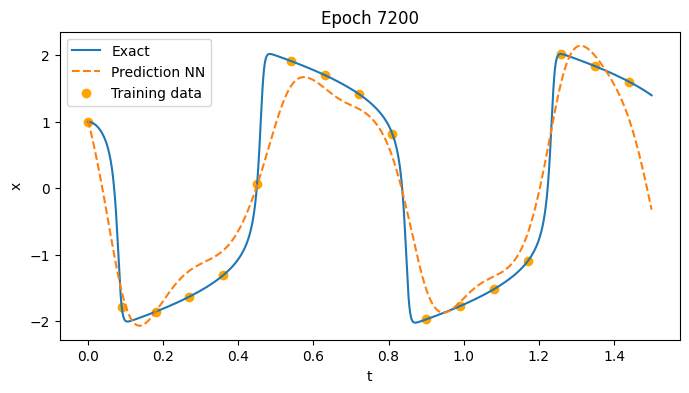

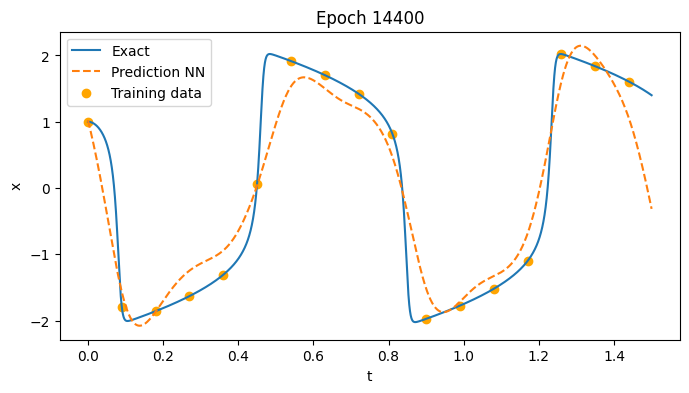

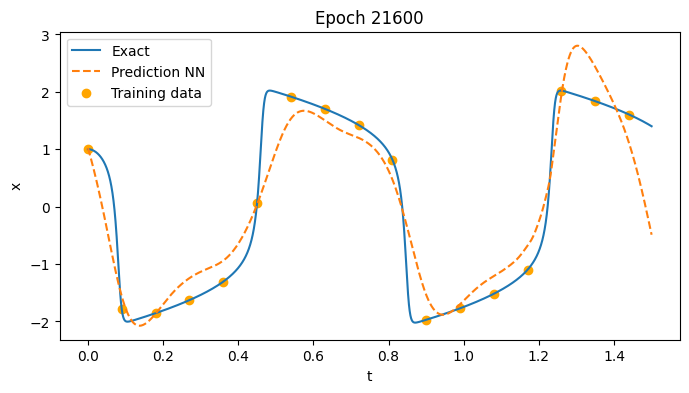

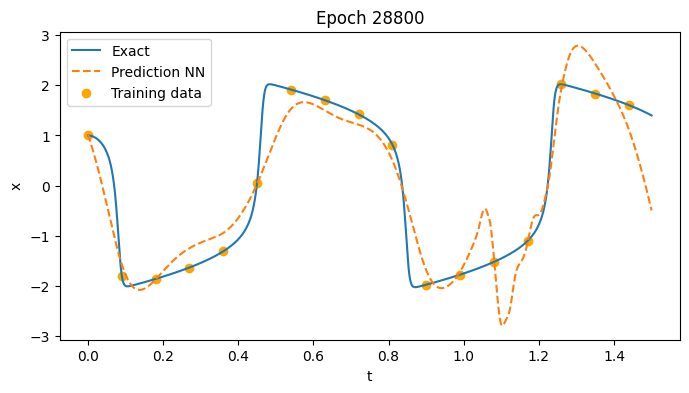

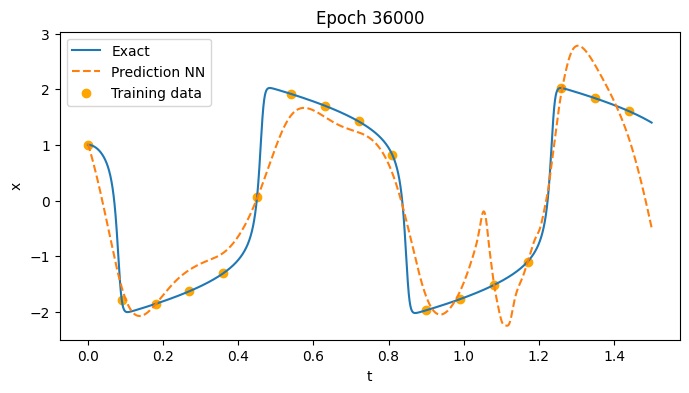

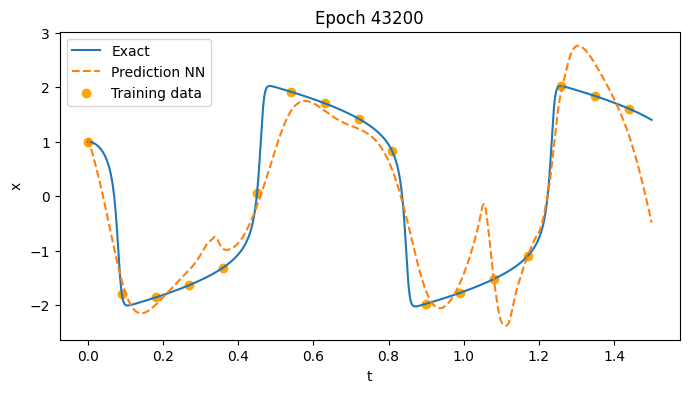

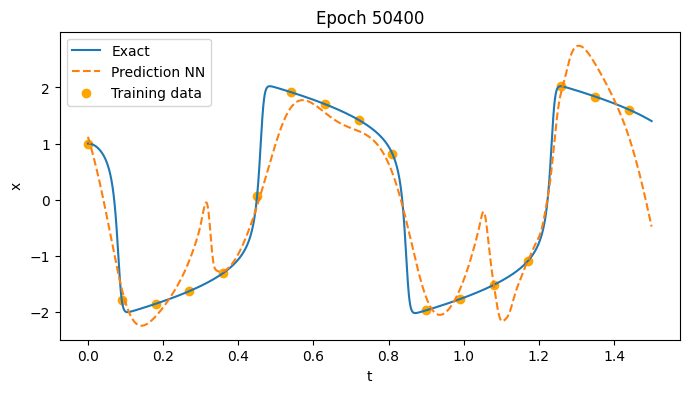

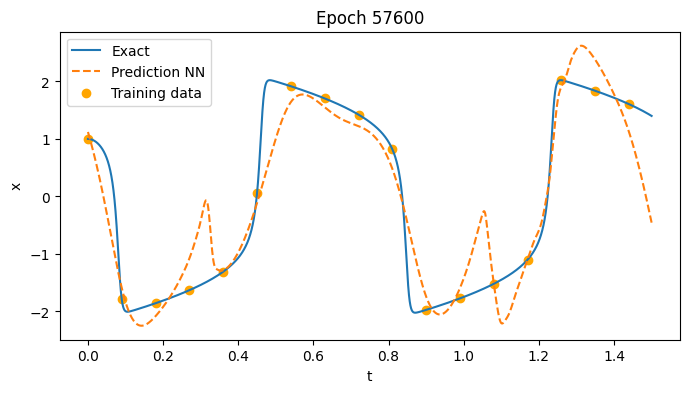

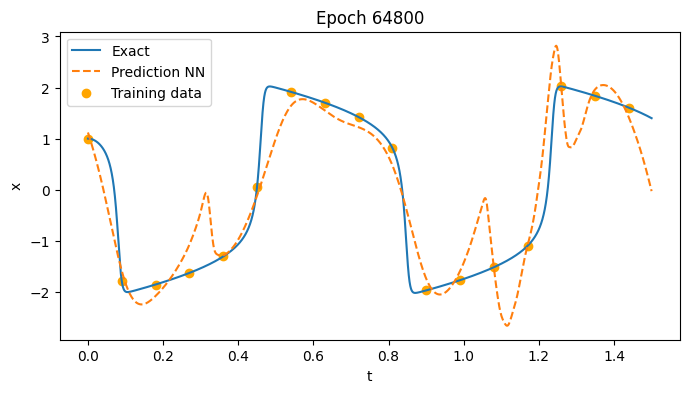

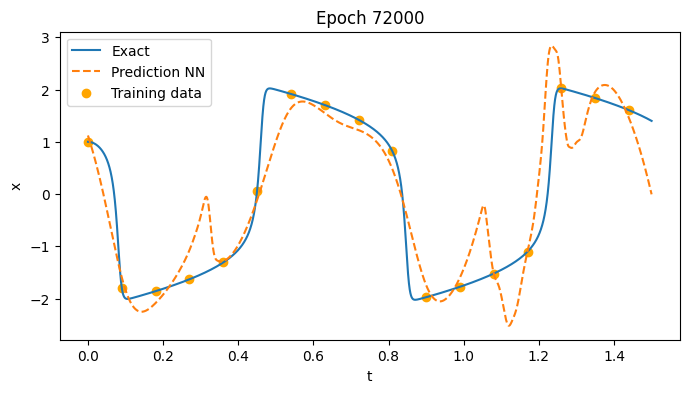

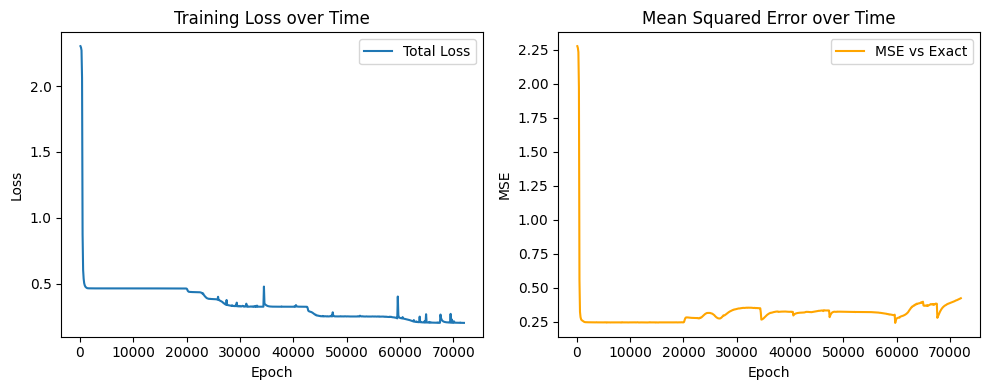

In [ ]:
#System parameters
omega = 15.
nu = 5.
tMin, tMax = 0.0, 1.5
r0 = [1.0, 0. ] #Initial conditions
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)
sol = odeint(vdp_oscillator, r0, tPoints, args=(omega, nu,))
xPoints = sol[:, 0]
vPoints = sol[:, 1]

#Learning parameters
epochs = 72000
plot_interval = 7200
Nc = 70 #collocation points
w_d = 1.0
w_f = 1.e-5
sample_every = 10
train_range=(0, 1000)
train_stride=62
model, loss_history, mse_history = train_PINN(omega, nu, tMin, tMax, nSteps, epochs=epochs, plot_interval=plot_interval, sample_every = sample_every,
                                              train_range=train_range, train_stride=train_stride,Nc=Nc, w_d=w_d, w_f=w_f)
# Plot loss and MSE history
plot_training_history(loss_history, mse_history)

# ODE SYSTEM FOR VDP OSCILLATOR

Podemos reformular la ecuación diferencial de segundo orden como un sistema de dos ecuaciones de primer orden definiendo:

\begin{equation}
    y_1 = y, \quad y_2 = \frac{dy_1}{dt}.
\end{equation}

Entonces, la ecuación original:

\begin{equation}
    \frac{d^2 y}{dt^2} + \omega_0^2 y - \epsilon \omega_0 (1 - y^2) \frac{dy}{dt} = 0
\end{equation}

se reescribe como el siguiente sistema de ecuaciones:

\begin{equation}
    \begin{aligned}
        \frac{dy_1}{dt} &= y_2, \\
        \frac{dy_2}{dt} &= -\omega_0^2 y_1 + \epsilon \omega_0 (1 - y_1^2) y_2.
    \end{aligned}
\end{equation}



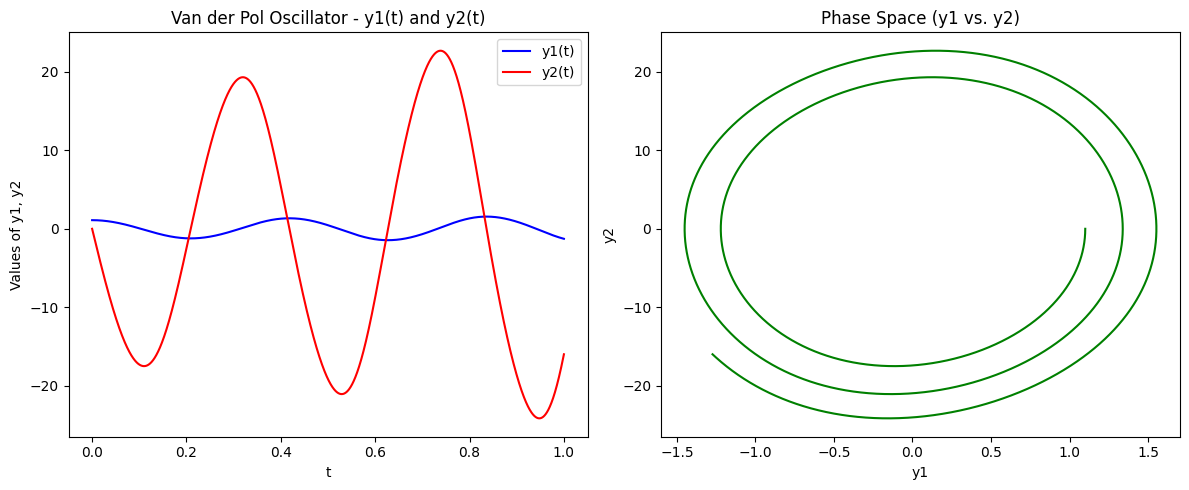

In [ ]:
# Define the Van der Pol oscillator system
def van_der_pol_system(r, t, omega0, epsilon):
    """
    r = [y1, y2]
    dy1/dt = y2
    dy2/dt = -omega0^2 * y1 + epsilon * omega0 * (1 - y1^2) * y2
    """
    y1, y2 = r
    dy1dt = y2
    dy2dt = -omega0**2 * y1 + epsilon * omega0 * (1 - y1**2) * y2
    return [dy1dt, dy2dt]

# Parameters
omega0 = 15.0  # Natural frequency
epsilon = 0.33  # Nonlinearity parameter
tMin, tMax = 0.0, 1.0  # Time range
nSteps = 10000  # Number of time steps
tPoints = np.linspace(tMin, tMax, nSteps)  # Time array

# Initial conditions
r0 = [1.1, 0.0]  # y1(0) = 1.0, y2(0) = 0.0

# Solve the system using odeint
sol = odeint(van_der_pol_system, r0, tPoints, args=(omega0, epsilon))
y1Points = sol[:, 0]  # y1(t)
y2Points = sol[:, 1]  # y2(t)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot y1(t) and y2(t) in the same subplot
axes[0].plot(tPoints, y1Points, label="y1(t)", color='blue')
axes[0].plot(tPoints, y2Points, label="y2(t)", color='red')
axes[0].set_xlabel("t")
axes[0].set_ylabel("Values of y1, y2")
axes[0].set_title("Van der Pol Oscillator - y1(t) and y2(t)")
axes[0].legend()

# Phase space plot
axes[1].plot(y1Points, y2Points, color='green')
axes[1].set_xlabel("y1")
axes[1].set_ylabel("y2")
axes[1].set_title("Phase Space (y1 vs. y2)")

# Adjust layout
plt.tight_layout()
plt.show()


Epoch 5000, Loss: 3.59790e+01


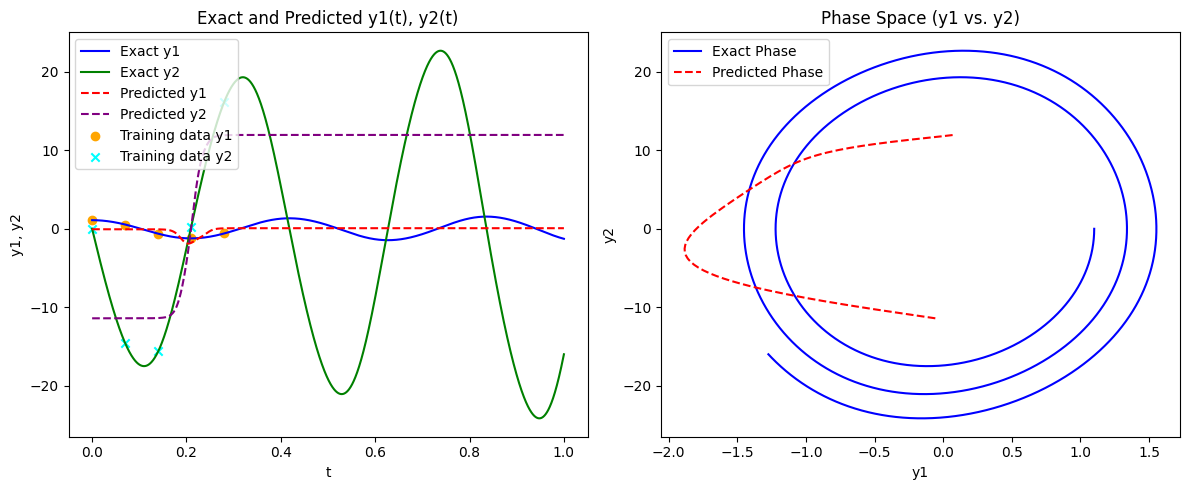

Epoch 10000, Loss: 3.42585e+01


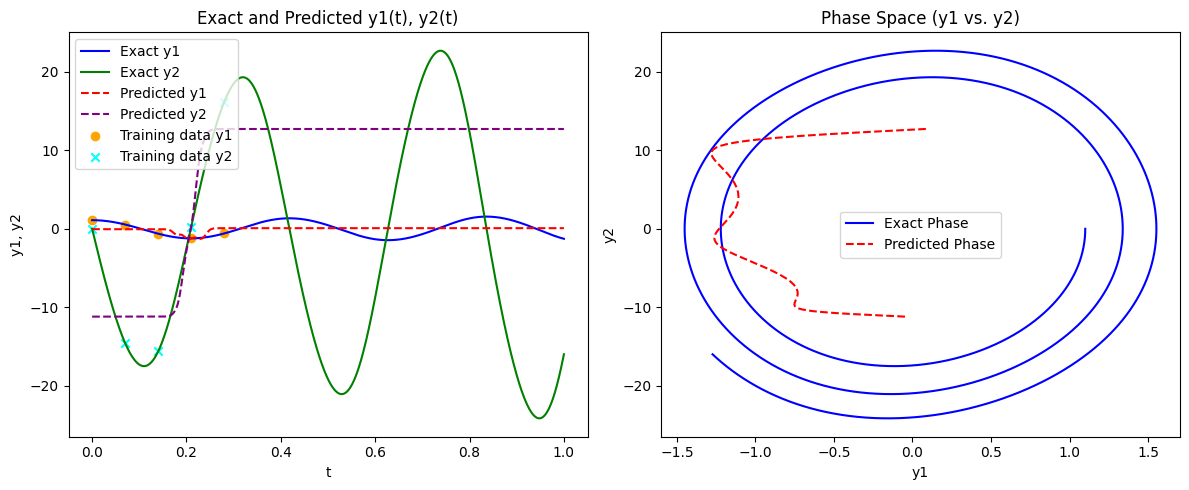

Epoch 15000, Loss: 3.30906e+01


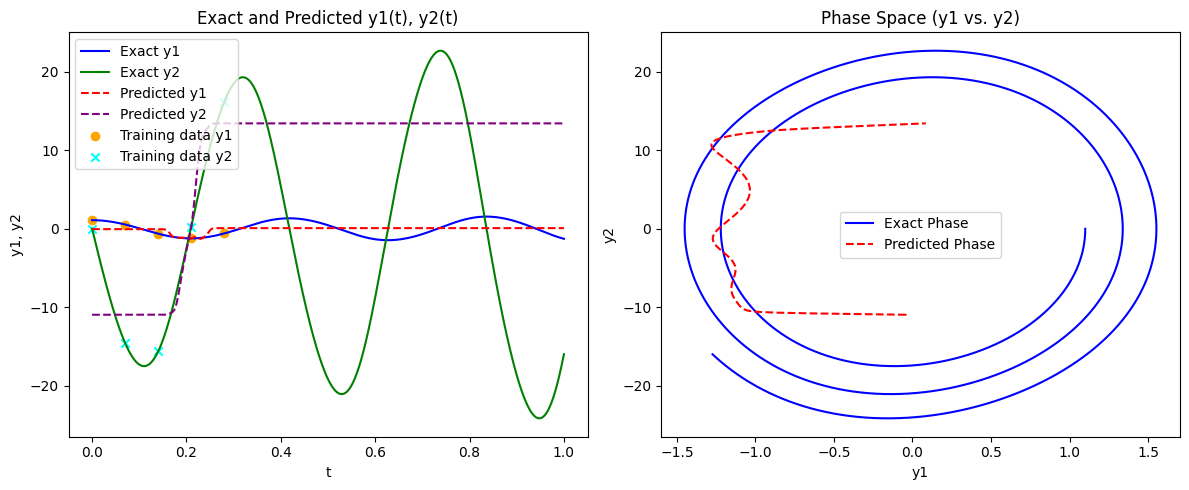

Epoch 20000, Loss: 2.78934e+01


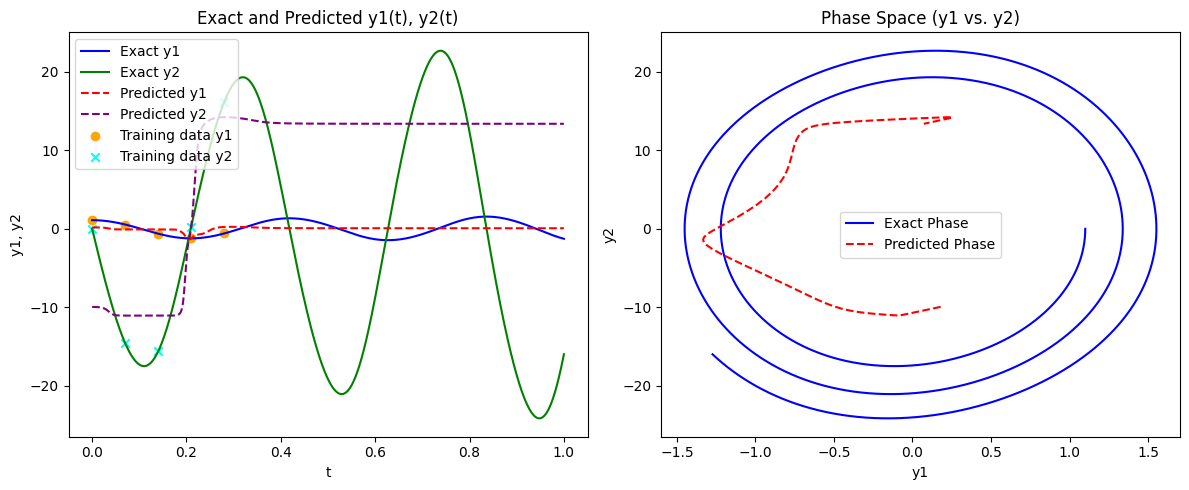

Epoch 25000, Loss: 1.97134e+01


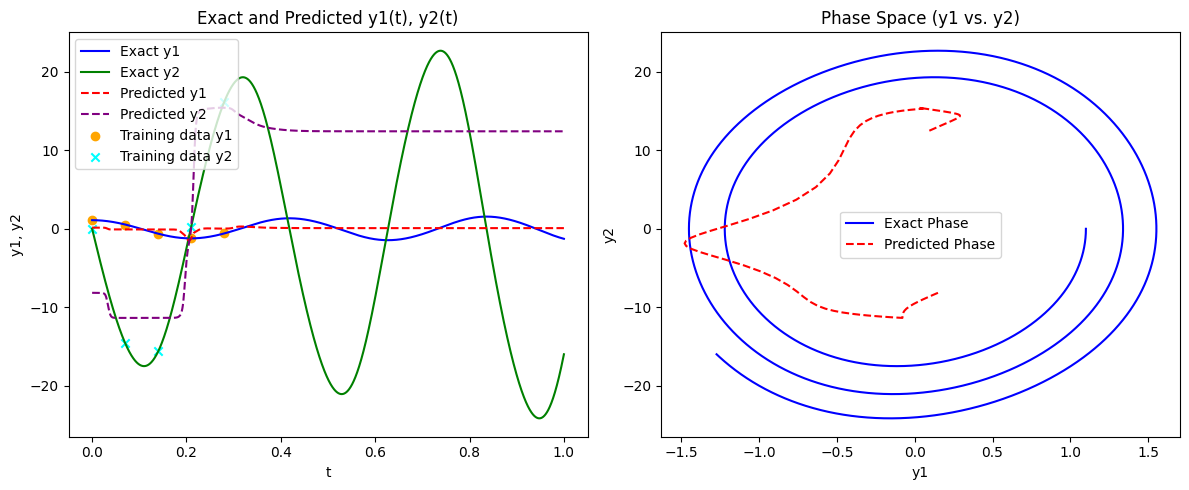

Epoch 30000, Loss: 1.38049e+01


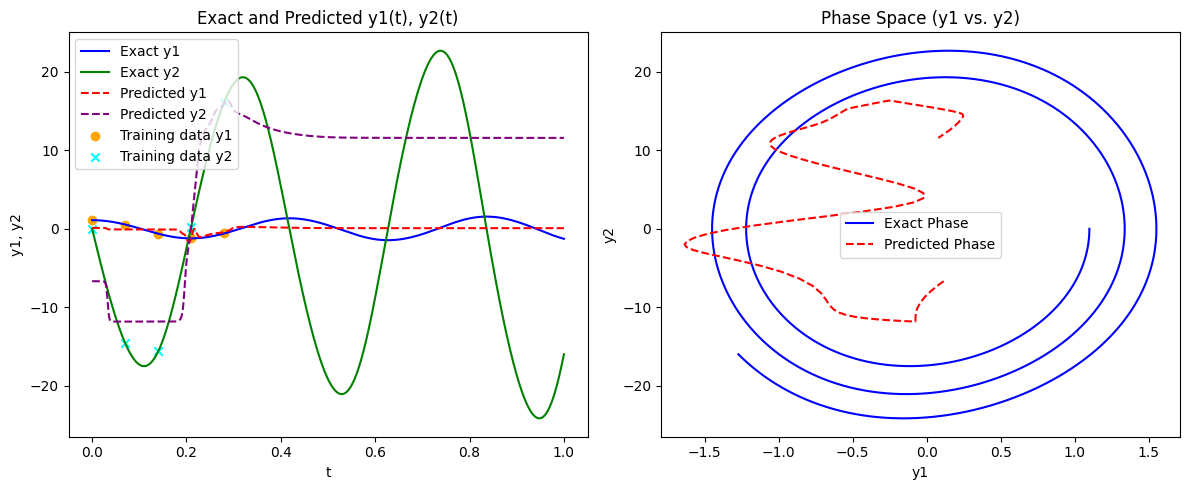

Epoch 35000, Loss: 9.15887e+00


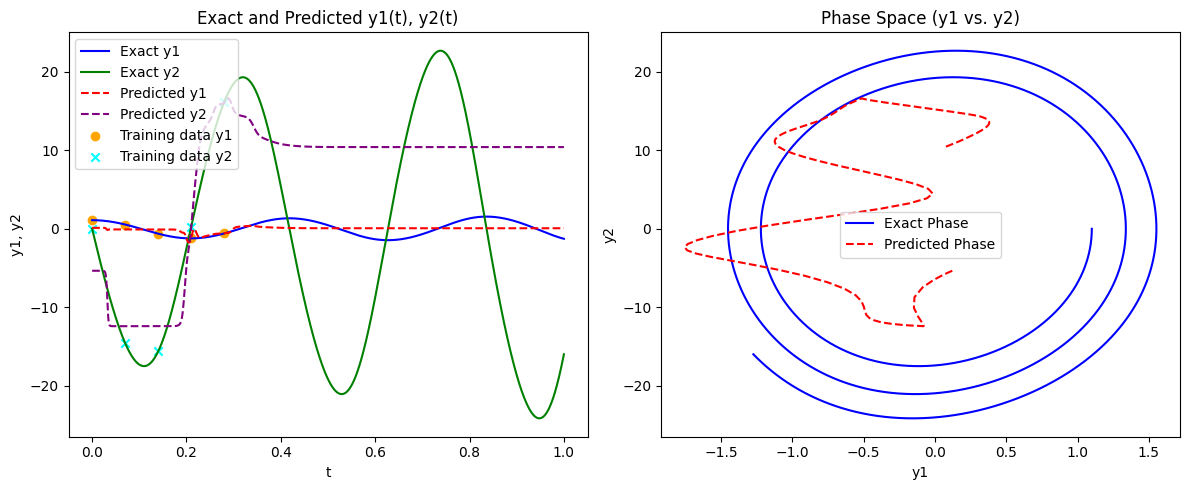

Epoch 40000, Loss: 5.54446e+00


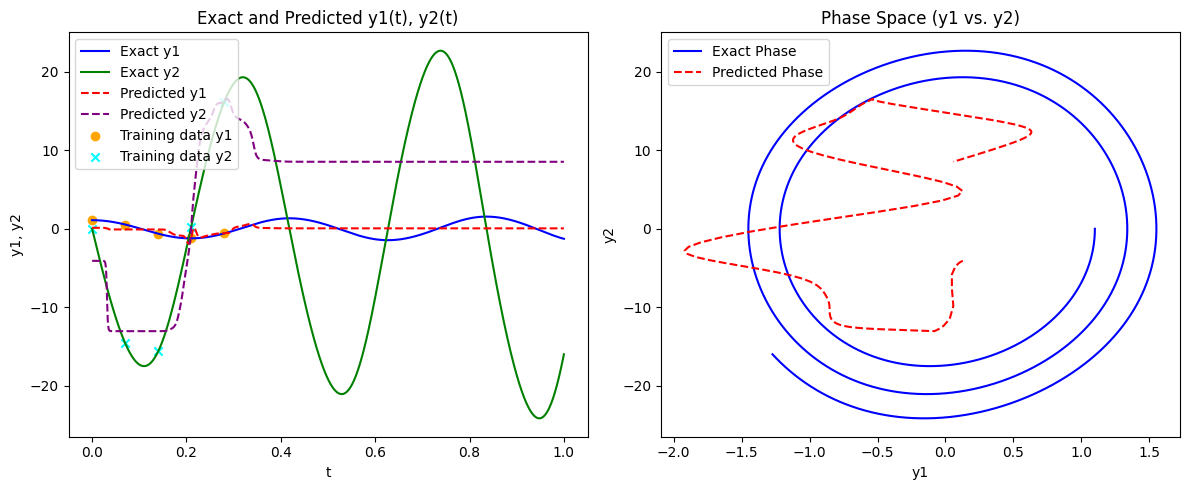

Epoch 45000, Loss: 2.94111e+00


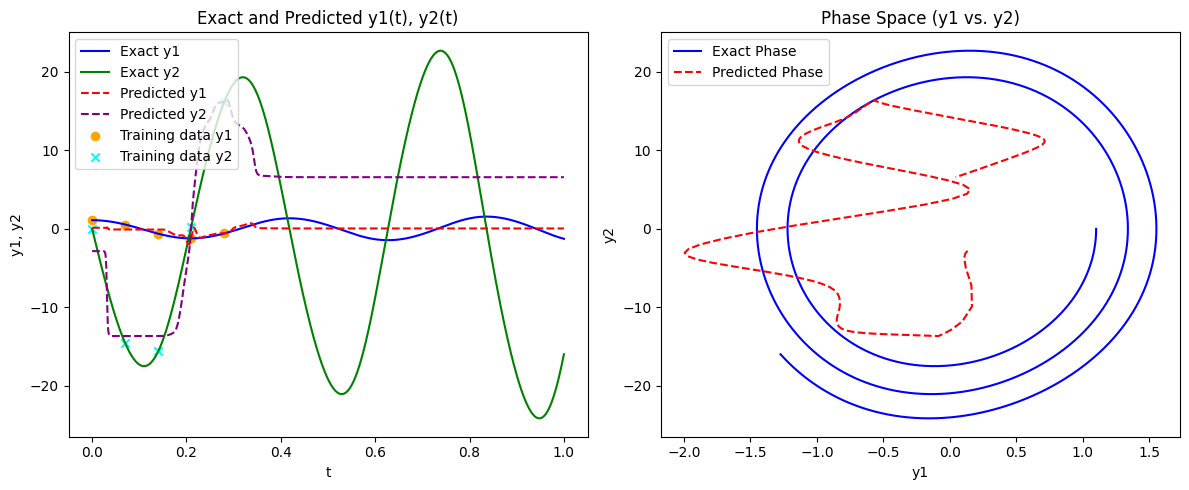

Epoch 50000, Loss: 1.31250e+00


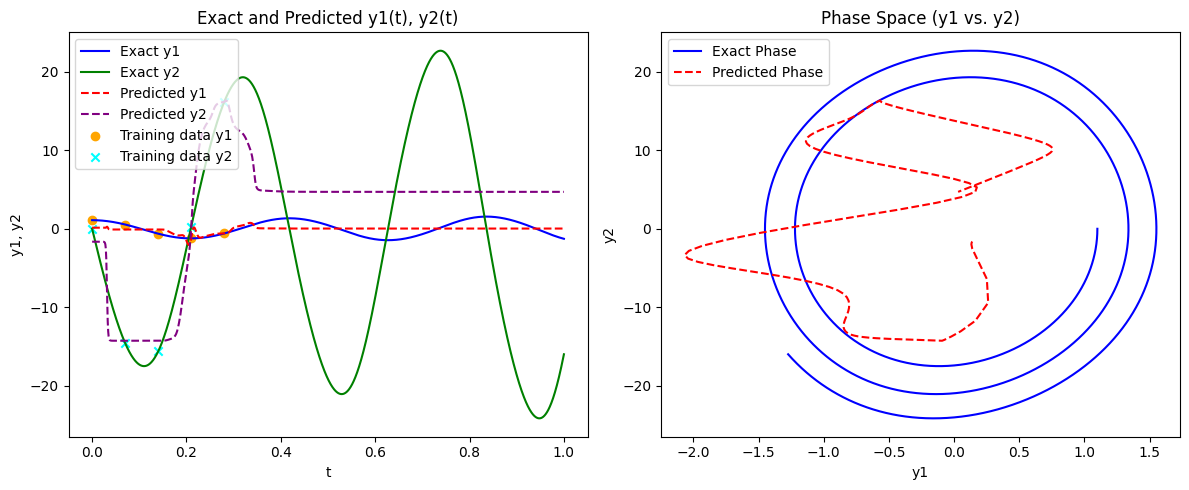

Epoch 55000, Loss: 5.85050e-01


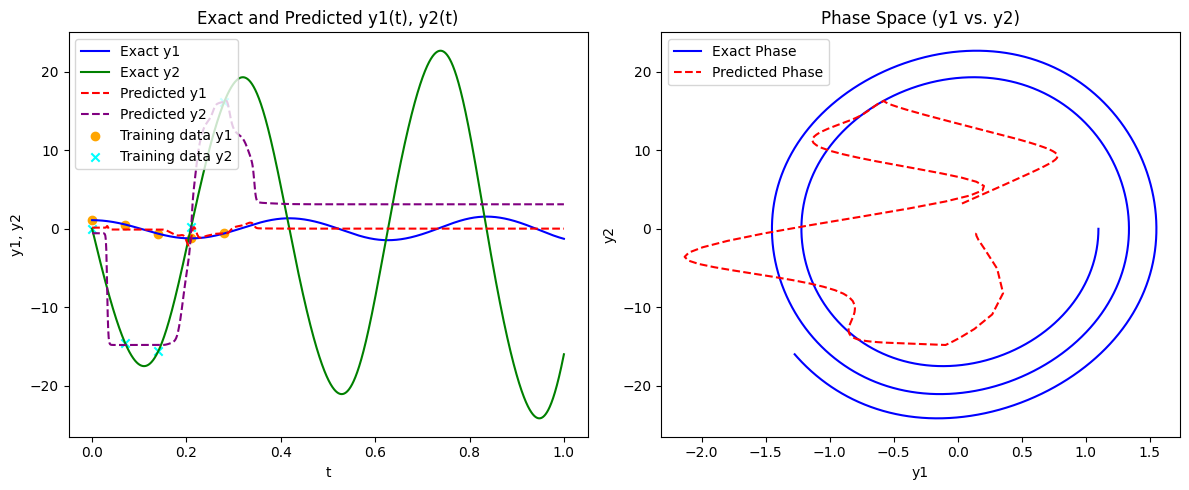

Epoch 60000, Loss: 4.83494e-01


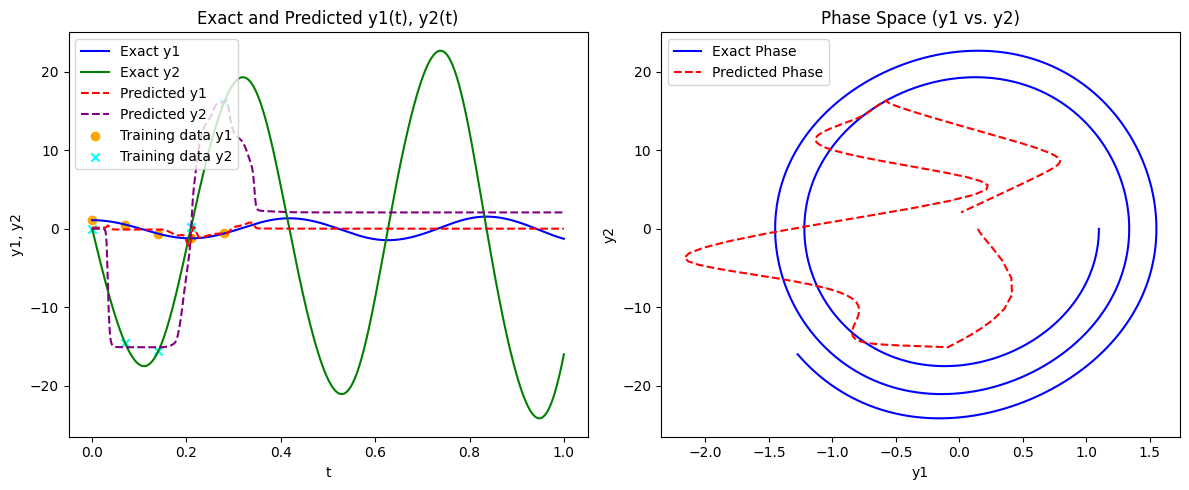

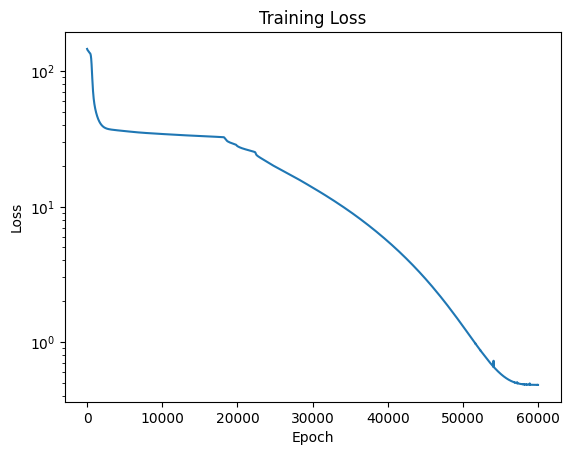

In [ ]:
x = torch.Tensor(tPoints).view(-1,1)
y1 = torch.Tensor(y1Points).view(-1,1)
y2 = torch.Tensor(y2Points).view(-1,1)

# Seleccionar algunos puntos (uno de cada 10) para comparación con la solución exacta
x = x[::10]
y1 = y1[::10, :]
y2 = y2[::10, :]

# Seleccionar solo 2 puntos de cada ecuación separados por un intervalo
x_data = x[0:350:70]   # t
y1_data = y1[0:350:70] # y1(t)
y2_data = y2[0:350:70] # y2(t)

# --------------------------------------------------------
# 4) Instanciar modelo y optimizador
# --------------------------------------------------------
model = FCN(in_dim=1, out_dim=2, hidden_dim=32, num_layers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Puntos de colocación (collocation points) para imponer la ecuación
x_physics = torch.linspace(tMin, tMax, 40).view(-1,1).requires_grad_(True)

loss_history = []

# --------------------------------------------------------
# 5) Entrenamiento de la PINN
# --------------------------------------------------------
for epoch in range(60000):
    optimizer.zero_grad()

    # (A) Data Loss: forzamos la red a cumplir y1(0)=0.1, y2(0)=1.6
    y_pred_data = model(x_data)   # [1,2]
    y1_pred_data = y_pred_data[:, 0:1]
    y2_pred_data = y_pred_data[:, 1:2]
    loss_data = torch.mean((y1_pred_data - y1_data)**2) + \
                torch.mean((y2_pred_data - y2_data)**2)

    y_pred_phys = model(x_physics)  # shape [40,2]
    y1_pred_phys = y_pred_phys[:, 0:1]
    y2_pred_phys = y_pred_phys[:, 1:2]

    dy1_dt = torch.autograd.grad(y1_pred_phys, x_physics,
                                 torch.ones_like(y1_pred_phys),
                                 create_graph=True)[0]
    dy2_dt = torch.autograd.grad(y2_pred_phys, x_physics,
                                 torch.ones_like(y2_pred_phys),
                                 create_graph=True)[0]

    physics1 = dy1_dt - y2_pred_phys
    physics2 = dy2_dt + omega0**2*y1_pred_phys - epsilon*omega0*(1-y1_pred_phys**2)*y2_pred_phys
    loss_physics = 1e-3* (torch.mean(physics1**2) + torch.mean(physics2**2))


    # (D) Pérdida total
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()


    loss_history.append(loss.item())
    if (epoch+1) % 5000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5e}")

        # ----
        # --------------------------------------------------------
        # 6) Validación y visualización de resultados
        # --------------------------------------------------------
        t_eval = torch.linspace(tMin, tMax, 1000).view(-1,1)
        y_eval = model(t_eval).detach().numpy()

        y1_eval = y_eval[:, 0]
        y2_eval = y_eval[:, 1]

        # Crear figura con dos subgráficos
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Primer subplot: y1(t) y y2(t) en la misma gráfica
        axes[0].plot(tPoints, y1Points, label='Exact y1', color='blue')
        axes[0].plot(tPoints, y2Points, label='Exact y2', color='green')
        axes[0].plot(t_eval.numpy(), y1_eval, '--', label='Predicted y1', color='red')
        axes[0].plot(t_eval.numpy(), y2_eval, '--', label='Predicted y2', color='purple')
        axes[0].scatter(x_data.detach().numpy(), y1_data.detach().numpy(),
                        color='orange', label='Training data y1', marker='o')
        axes[0].scatter(x_data.detach().numpy(), y2_data.detach().numpy(),
                        color='cyan', label='Training data y2', marker='x')
        axes[0].legend()
        axes[0].set_xlabel('t')
        axes[0].set_ylabel('y1, y2')
        axes[0].set_title("Exact and Predicted y1(t), y2(t)")

        # Segundo subplot: Espacio de fases
        axes[1].plot(y1Points, y2Points, label='Exact Phase', color='blue')
        axes[1].plot(y1_eval, y2_eval, '--', label='Predicted Phase', color='red')
        axes[1].legend()
        axes[1].set_xlabel('y1')
        axes[1].set_ylabel('y2')
        axes[1].set_title("Phase Space (y1 vs. y2)")

        # Ajustar diseño para evitar solapamientos
        plt.tight_layout()
        plt.show()


# Finalmente, graficamos la historia de la pérdida
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


# IMPROVING THE LEARNING

In [92]:
def plot_result(x,y,x_data,y_data,yh,xp=None, epoch=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Coloc. points')
    l = plt.legend(loc=(0.701,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05,2.05)
    plt.ylim(-2.3, 2.3)
    plt.text(1.525,0.9,"Step: %i"%(epoch+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
        

In [95]:
# General function to train a PINN model
def train_PINN_2(omega, nu, tMin, tMax, nSteps, epochs=72000, lr=7e-4, plot_interval=5000, 
               sample_every = 10,train_range=(0, 210), train_stride=70, Nc=48, w_d= 1.0, w_f = 1e-4):

    tPoints = np.linspace(tMin, tMax, nSteps)

    # Convert time points and solution into tensors
    x = torch.Tensor(tPoints).view(-1, 1)
    y = torch.Tensor(xPoints).view(-1, 1)

    # Subsample points for comparison
    x = x[::sample_every]
    y = y[::sample_every, :]

    # Select training data from range with given stride
    i_start, i_end = train_range
    x_data = x[i_start:i_end:train_stride]
    y_data = y[i_start:i_end:train_stride]

    # Define model, optimizer and training history containers
    torch.manual_seed(125)
    model = FCN(1, 1, 42, 4)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    mse_history = []

    # Define points for evaluating physics-based residuals
    x_plot = torch.linspace(tMin, tMax, 1000).view(-1, 1)


    for epoch in range(epochs):
        lim = 0.2 + np.minimum(1.3*epoch/74000.,1.3)
        x_physics = torch.linspace(0.,lim,80).view(-1,1).requires_grad_(True)#
        optimizer.zero_grad()

        # Compute loss from training data (data-driven loss)
        y_pred_data = model(x_data)
        loss_data_1 = w_d * torch.mean((y_pred_data - y_data) ** 2) 

        # Compute physics-informed loss (residual of differential equation)
        y_pred_physics = model(x_physics)
        dydx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]

        d2ydx2 = torch.autograd.grad(dydx, x_physics, torch.ones_like(dydx), create_graph=True)[0]

        loss_data_2 = 0.1*torch.max((dydx[0] )**2)

        loss_data = loss_data_1 + loss_data_2

        physics_residual = d2ydx2 + omega**2 * y_pred_physics - nu*omega * (1 - y_pred_physics**2) * dydx
        loss_physics = w_f* torch.mean(physics_residual ** 2)

        # Compute mean squared error against full exact solution (evaluation only)
        yhpp = model(x)
        mse = torch.mean((yhpp - y) ** 2)

        # Combine losses and backpropagate
        loss = loss_data + loss_physics
        loss.backward()
        optimizer.step()

        # Save and optionally plot training progress
        if (epoch + 1) % 100 == 0:
            loss_history.append(loss.detach().item())
            mse_history.append(mse.detach().item())

            yh = model(x).detach()
            xp = x_physics.detach()
            yhpp=model(x)
            mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....


            plot_result(x, y, x_data, y_data, yh, xp, epoch)
            
            if (epoch+1) % 3000 == 0: plt.show()
            else: plt.close("all")

    return model, loss_history, mse_history

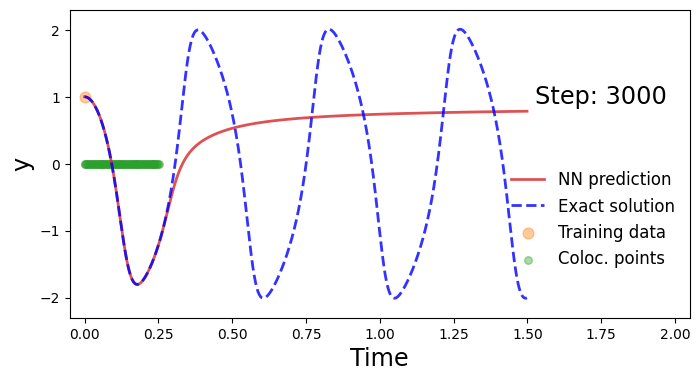

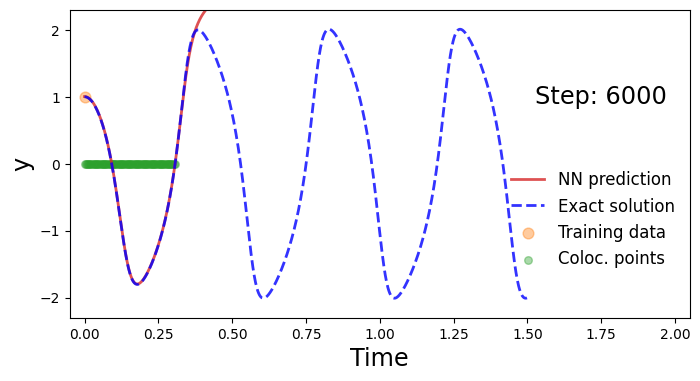

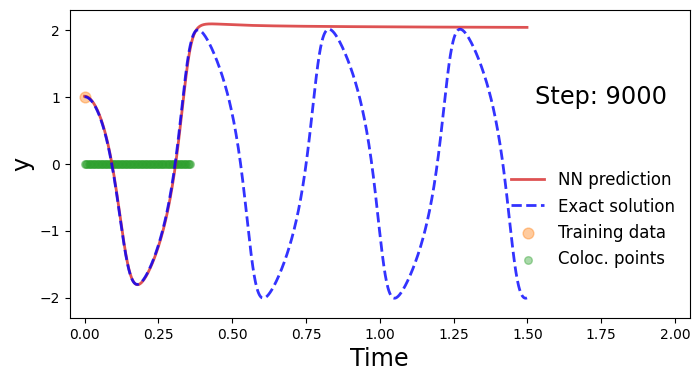

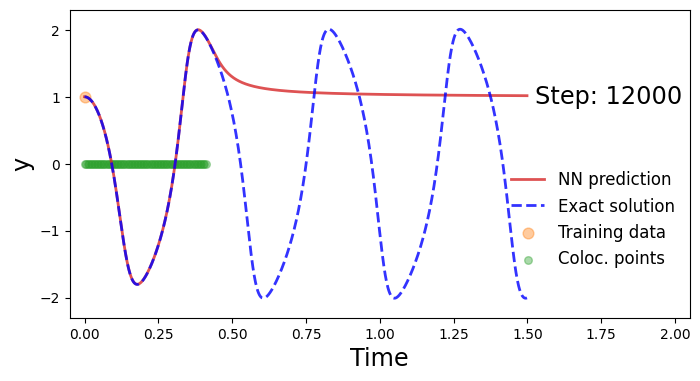

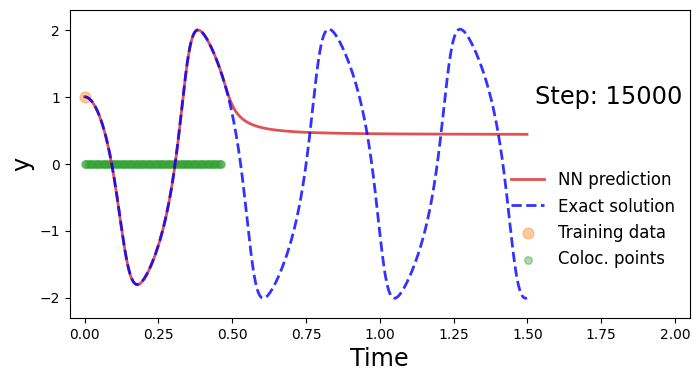

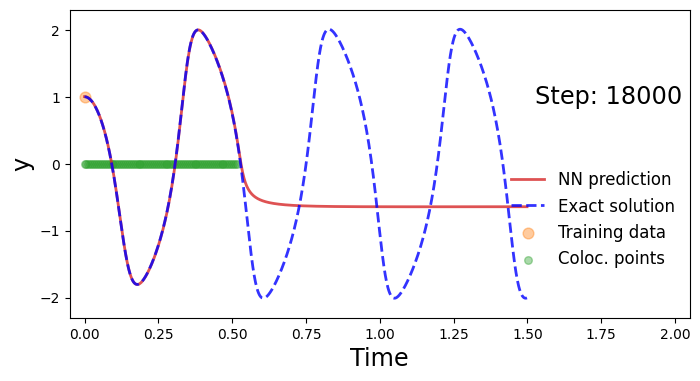

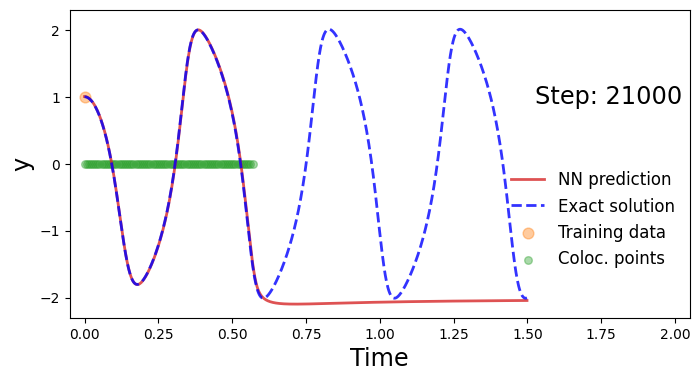

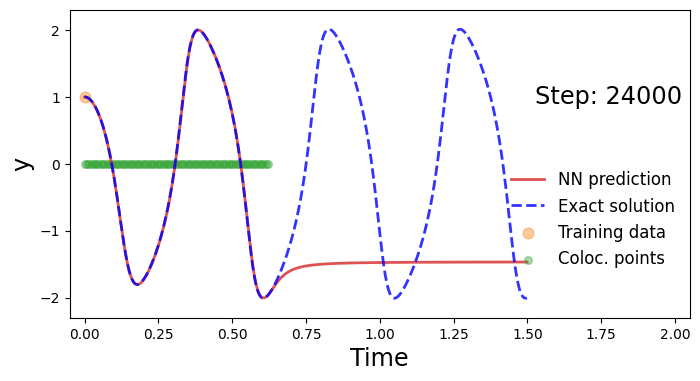

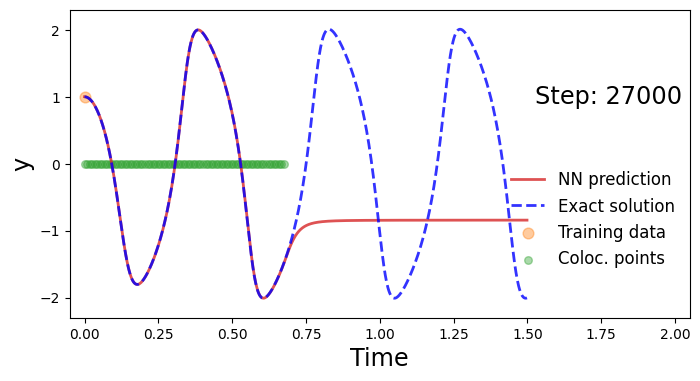

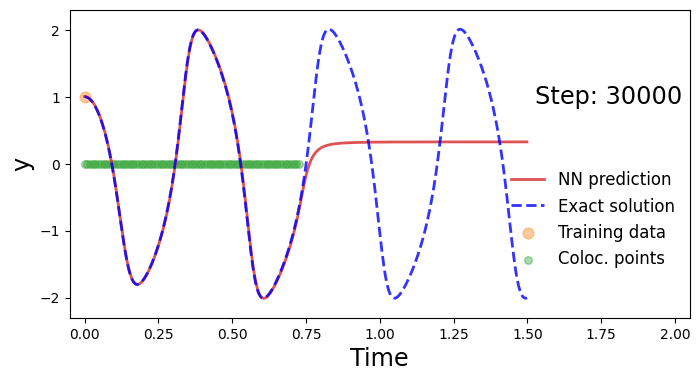

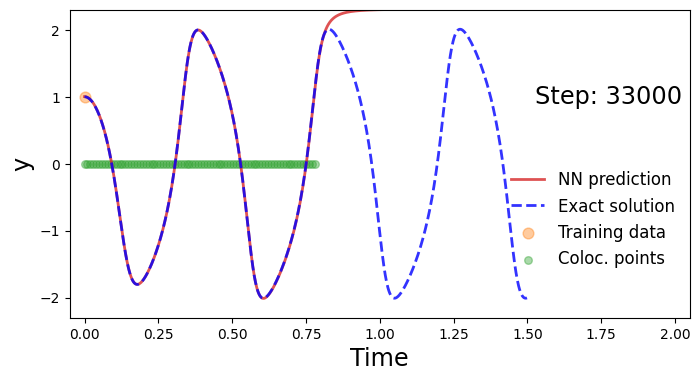

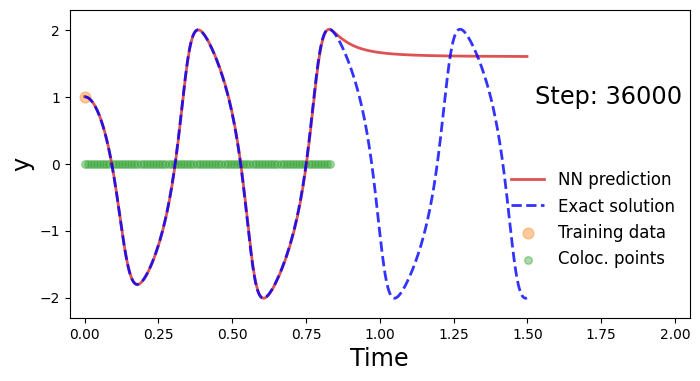

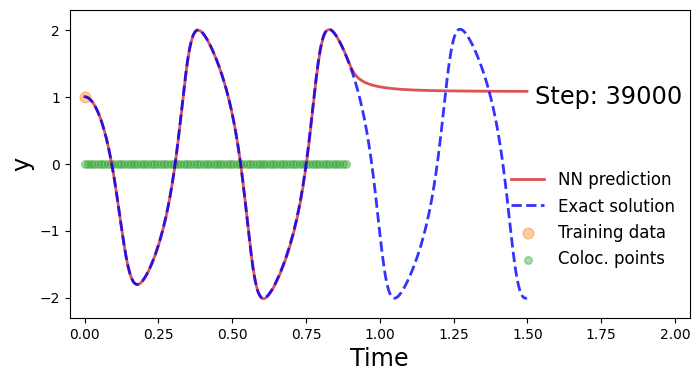

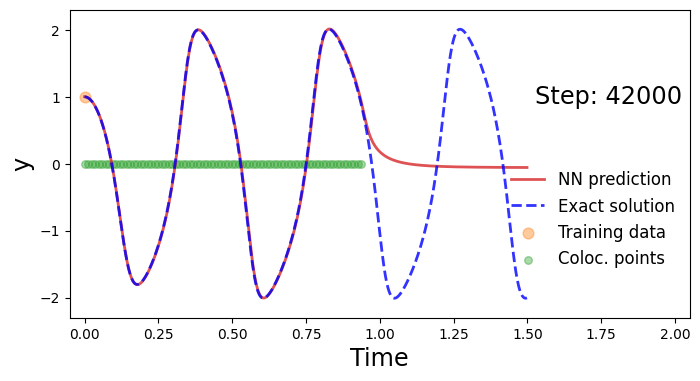

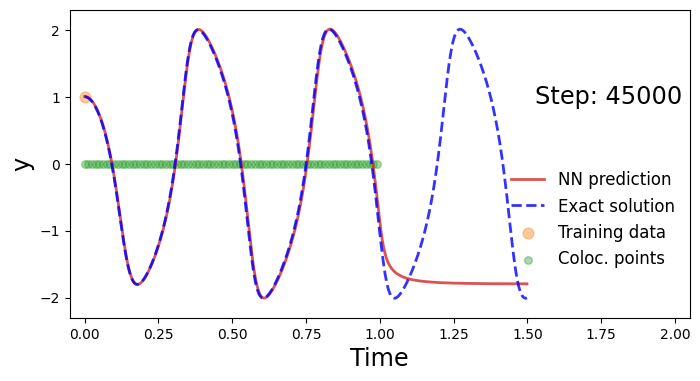

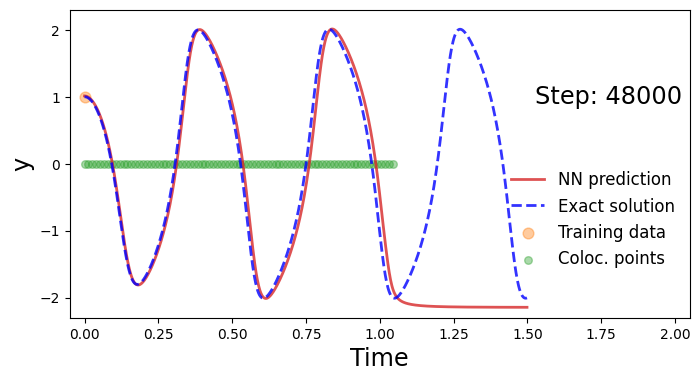

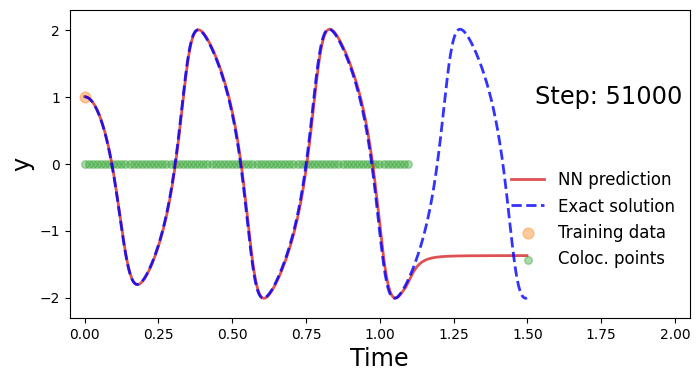

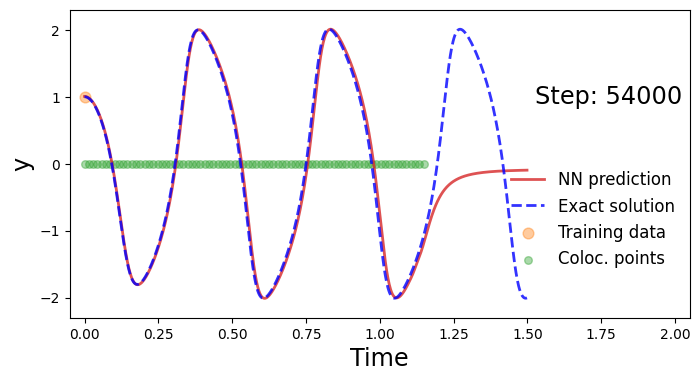

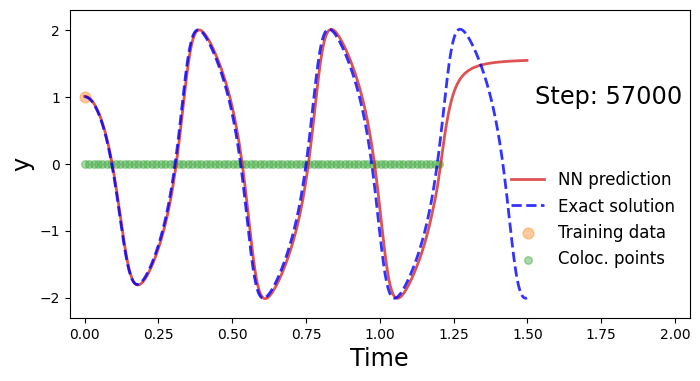

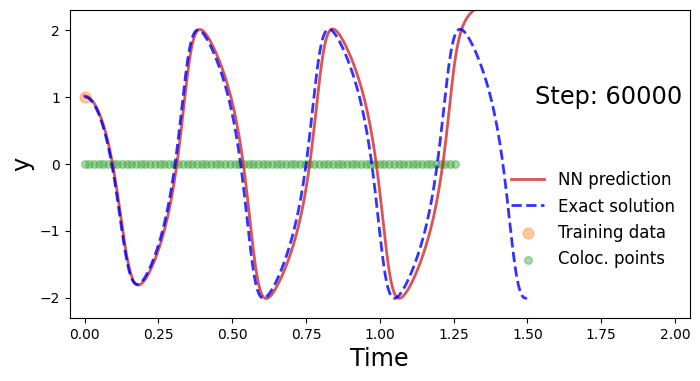

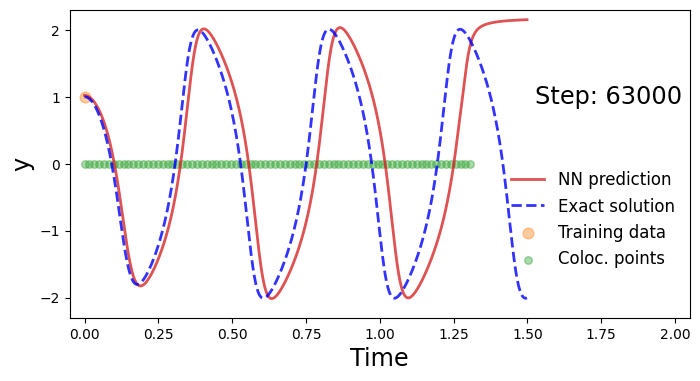

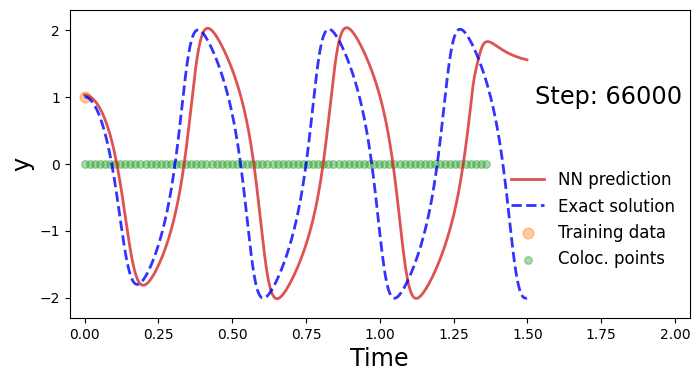

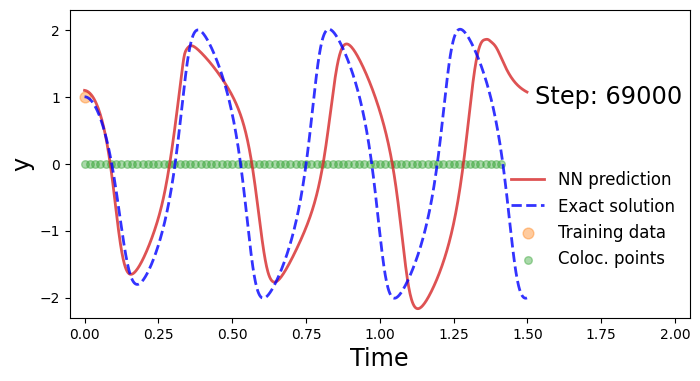

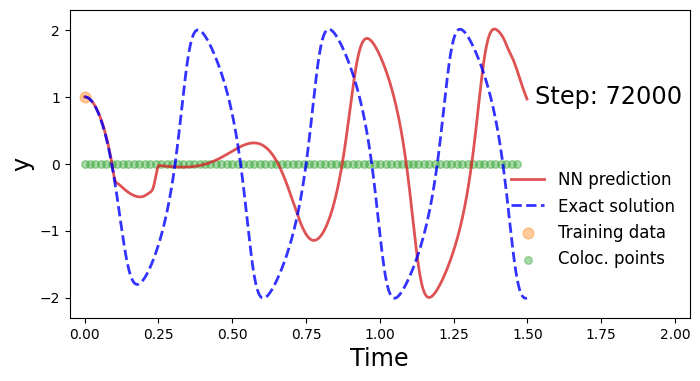

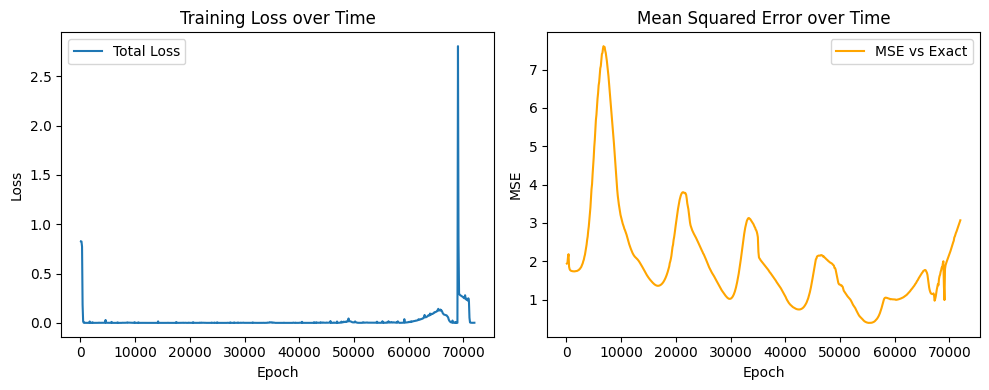

In [96]:
#System parameters
omega = 15.
nu = 1.
tMin, tMax = 0.0, 1.5
r0 = [1.0, 0. ] #Initial conditions
nSteps = 10000
tPoints = np.linspace(tMin, tMax, nSteps)
sol = odeint(vdp_oscillator, r0, tPoints, args=(omega, nu,))
xPoints = sol[:, 0]
vPoints = sol[:, 1]

#Learning parameters
epochs = 72000
plot_interval = 7200
Nc = 48 #collocation points
w_d = 1.0
w_f = 1.e-4
sample_every = 10
train_range=(0, 20)
train_stride=20
model, loss_history, mse_history = train_PINN_2(omega, nu, tMin, tMax, nSteps, epochs=epochs, plot_interval=plot_interval, sample_every = sample_every,
                                              train_range=train_range, train_stride=train_stride,Nc=Nc, w_d=w_d, w_f=w_f)
# Plot loss and MSE history
plot_training_history(loss_history, mse_history)